# Detrend and Estimate Noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly
import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
from   scipy import ndimage
from   scipy.interpolate import UnivariateSpline
import astropy
from   astropy.io import fits as pyfits
from   sklearn.cluster import KMeans

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json
from   copy import deepcopy

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import theano
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise

# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# LCIT and SCIT in [days]
lcit = LCIT/60/24
scit = SCIT/3600/24

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE
#### Note that if using DR25, you will need to manually correct epochs from BJD to BJKD with an offset of 2454833.0 days; the cumulative exoplanet archive catalog has already converted epochs to BJKD

In [2]:
# select mission, target, and paths
MISSION = "Simulated"
TARGET  = "S00123"
PRIMARY_DIR  = '/Users/research/projects/alderaan/'

if MISSION == "Kepler":
    CSV_FILE = PRIMARY_DIR + "Catalogs/cumulative_koi_catalog.csv"
    
if MISSION == "Simulated":
    CSV_FILE = PRIMARY_DIR + "Catalogs/simulated_catalog.csv"

In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--csv_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing input planetary parameters")


    args = parser.parse_args()
    MISSION      = args.mission
    TARGET       = args.target
    PRIMARY_DIR  = args.primary_dir
    CSV_FILE     = args.csv_file    
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET
                             --primary_dir PRIMARY_DIR --csv_file CSV_FILE
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --primary_dir, --csv_file


# Make sure the necessary paths exist

In [4]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in planet and stellar parameters

In [5]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    KOI_ID = TARGET
    
elif MISSION == 'Simulated':
    KOI_ID = "K" + TARGET[1:]

else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")
    
    
# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['koi_id']) == KOI_ID

KIC = np.array(target_dict['kic_id'], dtype='int')[use]
NPL = np.array(target_dict['npl'], dtype='int')[use]

RSTAR = np.array(target_dict['rstar'],  dtype='float')[use]
RSTAR_ERR1 = np.array(target_dict['rstar_err1'],  dtype='float')[use]
RSTAR_ERR2 = np.array(target_dict['rstar_err2'],  dtype='float')[use]

MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]
MSTAR_ERR1 = np.array(target_dict['mstar_err1'],  dtype='float')[use]
MSTAR_ERR2 = np.array(target_dict['mstar_err2'],  dtype='float')[use]

U1 = np.array(target_dict['limbdark_1'], dtype='float')[use]
U2 = np.array(target_dict['limbdark_2'], dtype='float')[use]

PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> []
DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]
IMPACTS = np.array(target_dict['impact'], dtype='float')[use]

Reading in data from csv file


In [6]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(r == RSTAR_ERR1[0] for r in RSTAR_ERR1): RSTAR_ERR1 = RSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR1 in the csv input file')
    
if all(r == RSTAR_ERR2[0] for r in RSTAR_ERR2): RSTAR_ERR2 = RSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR2 in the csv input file')  
    
if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

if all(m == MSTAR_ERR1[0] for m in MSTAR_ERR1): MSTAR_ERR1 = MSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR1 in the csv input file')
    
if all(m == MSTAR_ERR2[0] for m in MSTAR_ERR2): MSTAR_ERR2 = MSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR2 in the csv input file')
    
if all(u == U1[0] for u in U1): U1 = U1[0]
else: raise ValueError('There are inconsistencies with U1 in the csv input file')

if all(u == U2[0] for u in U2): U2 = U2[0]
else: raise ValueError('There are inconsistencies with U2 in the csv input file')

In [7]:
# combline stellar radius/mass uncertainties
MSTAR_ERR = np.sqrt(MSTAR_ERR1**2 + MSTAR_ERR2**2)/np.sqrt(2)
RSTAR_ERR = np.sqrt(RSTAR_ERR1**2 + RSTAR_ERR2**2)/np.sqrt(2)

# limb darkening coefficients
UCOEFFS = [U1, U2]

# Read in CDPP values

In [8]:
temp = []

with open(PRIMARY_DIR + "Catalogs/keplerstellar_cdpp.txt", "r") as file:
    temp = [line.rstrip('\n').split(",") for line in file]
    
    
keys = temp[0]
vals = temp[1:]

data = {}

for i, k in enumerate(keys):
    data[k] = []
    
    for j, v in enumerate(vals):
        data[k].append(v[i])

for k in data.keys():
    data[k] = np.array(data[k])
    
data["cdpp03"] = data.pop("rrmscdpp03p0")
data["cdpp06"] = data.pop("rrmscdpp06p0")
data["cdpp09"] = data.pop("rrmscdpp09p0")
data["cdpp12"] = data.pop("rrmscdpp12p0")
data["cdpp15"] = data.pop("rrmscdpp15p0")

for k in data.keys():
    empty = data[k] == ""
    
    data[k][empty] = "-99"
    
    try:
        data[k] = np.array(data[k], dtype="float")
        data[k][empty] = np.nan
    except:
        pass

data["kepid"] = np.array(data["kepid"], dtype="int")


use = data["kepid"] == KIC

c03 = np.nanmean(data["cdpp03"][use])
c06 = np.nanmean(data["cdpp06"][use])
c09 = np.nanmean(data["cdpp09"][use])
c12 = np.nanmean(data["cdpp12"][use])
c15 = np.nanmean(data["cdpp15"][use])

CDPP = np.array([c03, c06, c09, c12, c15])

# Read in Holczer+ 2016 TTVs

In [9]:
HOLCZER_FILE = PRIMARY_DIR + "Catalogs/holczer_2016_kepler_ttvs.txt"

if MISSION == "Kepler":
    holczer_data = np.loadtxt(HOLCZER_FILE, usecols=[0,1,2,3])

    holczer_inds = []
    holczer_tts  = []
    holczer_pers = []

    for npl in range(NPL):
        koi = int(TARGET[1:]) + 0.01*(1+npl)
        use = np.isclose(holczer_data[:,0], koi, rtol=1e-10, atol=1e-10)
        
        # Holczer uses BJD -24548900; BJKD = BJD - 2454833
        if np.sum(use) > 0:
            holczer_inds.append(np.array(holczer_data[use,1], dtype="int"))
            holczer_tts.append(holczer_data[use,2] + holczer_data[use,3]/24/60 + 67)
            holczer_pers.append(np.median(holczer_tts[npl][1:] - holczer_tts[npl][:-1]))
            
        else:
            holczer_inds.append(None)
            holczer_tts.append(None)
            holczer_pers.append(np.nan)
            
    holczer_pers = np.asarray(holczer_pers)

# Read in pre-downloaded lightcurve data
#### Kepler data can be retrieved by running the script "download_from_MAST.py"
#### Simulated data can be produced by running the script "simulate_lightcurve.py"

In [10]:
# short cadence
try:
    if MISSION == 'Kepler':
        sc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            oscfi = lk.search.open(sc_files[i])
            sc_rawdata_list.append(oscfi)

        sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        
    elif MISSION == 'Simulated':
        sc_path = DOWNLOAD_DIR + 'Lightcurves/Kepler/simkplr' + '{0:09d}'.format(KIC) + '_sc/'
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            sc_rawdata_list.append(io.load_sim_fits(scf))


        quarters = []
        for i, scrd in enumerate(sc_rawdata_list):
            quarters.append(scrd.quarter)

        order = np.argsort(quarters)

        sc_data_list = []
        for j, q in enumerate(quarters):
            sc_data_list.append(sc_rawdata_list[order[j]])

        sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
        sc_data = lk.LightCurveCollection(sc_data_list)
        
        
except:
    sc_data = []

    
sc_quarters = []
for i, scd in enumerate(sc_data):
    sc_quarters.append(scd.quarter)    

In [11]:
# long cadence
if MISSION == 'Kepler':
    lc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]
    lc_files = glob.glob(lc_path + '*')

    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        olcfi = lk.search.open(lc_files[i])

        if ~np.isin(olcfi.quarter, sc_quarters):
            lc_rawdata_list.append(olcfi)

    lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
    lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)
    
    
elif MISSION == 'Simulated':
    lc_path = DOWNLOAD_DIR + 'Lightcurves/Kepler/simkplr' + '{0:09d}'.format(KIC) + '_lc/'
    lc_files = glob.glob(lc_path + '*')
    
    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        lc_rawdata_list.append(io.load_sim_fits(lcf))
        
    
    quarters = []
    for i, lcrd in enumerate(lc_rawdata_list):
        quarters.append(lcrd.quarter)
        
    order = np.argsort(quarters)
    
    lc_data_list = []
    for j, q in enumerate(quarters):
        lc_data_list.append(lc_rawdata_list[order[j]])

    lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
    lc_data = lk.LightCurveCollection(lc_data_list)
    
    
lc_quarters = []
for i, lcd in enumerate(lc_data):
    lc_quarters.append(lcd.quarter)

In [12]:
# determine the time baseline
time_min = []
time_max = []

try:
    for i, scd in enumerate(sc_data):
        time_min.append(scd.time.min())
        time_max.append(scd.time.max())
        
except:
    pass


try:
    for i, lcd in enumerate(lc_data):
        time_min.append(lcd.time.min())
        time_max.append(lcd.time.max())
        
except:
    pass
    
    
TIME_START = np.min(time_min)
TIME_END   = np.max(time_max)

if TIME_START < 0:
    raise ValueError("START TIME [BKJD] is negative...this will cause problems")


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Initialize Planet objects

In [13]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.depth    = DEPTHS[npl]
    p.duration = DURS[npl]
    p.impact   = IMPACTS[npl]
    
    if p.impact > 1 - np.sqrt(p.depth):
        p.impact = (1 - np.sqrt(p.depth))**2
        
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, TIME_END, p.period)

    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # add to list
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 2 Planet objects


# For simulated data, initilize with true TTVs + noise
#### Synthetic "Holczer" TTVs are approximated as ground truth + Student-t2 noise

In [14]:
if MISSION == "Simulated":
    holczer_inds = []
    holczer_tts  = []
    holczer_pers = []
    
    for npl, p in enumerate(planets):
        # read in the "ground truth" TTVs
        fname_in = DOWNLOAD_DIR + "TTVs/" + TARGET + "_0{0}_sim_ttvs.txt".format(npl)
        data_in  = np.loadtxt(fname_in).swapaxes(0,1)
    
        inds = np.array(data_in[0], dtype="int")
        tts_true  = np.array(data_in[1], dtype="float")
        
        # add some noise and reject transits without photometry cover
        tts_noisy = tts_true + stats.t.rvs(df=2, size=len(tts_true))*p.duration/3
        
        keep = np.zeros(len(tts_noisy), dtype="bool")
        
        for i, t0 in enumerate(tts_noisy):
            for j, scd in enumerate(sc_data):
                if np.min(np.abs(scd.time - t0)) < p.duration:
                    keep[i] = True
            for j, lcd in enumerate(lc_data):
                if np.min(np.abs(lcd.time - t0)) < p.duration:
                    keep[i] = True
        
        holczer_inds.append(inds[keep])
        holczer_tts.append(tts_noisy[keep])
        holczer_pers.append(p.period)
        
        
    holczer_pers = np.array(holczer_pers)

# Smooth and interpolate Holczer TTVs where they exist


PLANET 0


optimizing logp for variables: [logvar, mean, log_rho, log_sigma]
25it [00:12,  1.95it/s, logp=5.633862e+01] 
message: Optimization terminated successfully.
logp: 28.277350227685005 -> 56.3386162425011


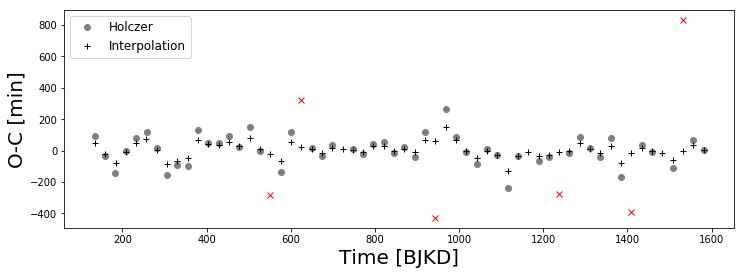


PLANET 1


optimizing logp for variables: [logvar, mean, log_rho, log_sigma]
29it [00:14,  1.99it/s, logp=1.951730e+01] 
message: Optimization terminated successfully.
logp: 2.9278468346320548 -> 19.51729612780578


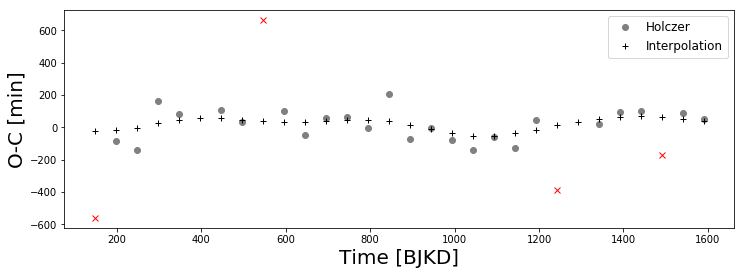

In [15]:
for npl in range(NPL):
    print("\nPLANET", npl)
    try:
        # fit a linear ephemeris 
        pfit  = poly.polyfit(holczer_inds[npl], holczer_tts[npl], 1)
        ephem = poly.polyval(holczer_inds[npl], pfit)
        
        
        # put fitted epoch in range (TIME_START, TIME_START + PERIOD)
        hepoch, hper = pfit

        if hepoch < TIME_START:
            adj = 1 + (TIME_START - hepoch)//hper
            hepoch += adj*hper       

        if hepoch > (TIME_START + hper):
            adj = (hepoch - TIME_START)//hper
            hepoch -= adj*hper      

        hephem = np.arange(hepoch, TIME_END, hper)        
        hinds  = np.array(np.round((hephem-hepoch)/hper),dtype='int')
        
        
        # calculate OMC and flag outliers
        xtime = np.copy(holczer_tts[npl])
        yomc  = (holczer_tts[npl] - ephem)

        ymed = ndimage.median_filter(yomc, size=5, mode="mirror")
        out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 3.0
                
        # set up a GP using a Matern-3/2 kernel
        with pm.Model() as holczer_model:

            # build the kernel 
            log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=10)
            log_rho = pm.Normal("log_rho", mu=np.log(xtime[1]-xtime[0]), sd=10)

            kernel = exo.gp.terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)

            # nusiance parameters
            mean = pm.Normal("mean", mu=np.mean(yomc), sd=10)
            logvar = pm.Normal("logvar", mu=np.log(np.var(yomc)), sd=10)

            # here's the GP
            gp = exo.gp.GP(kernel, xtime[~out], T.exp(logvar)*T.ones(len(xtime[~out])))

            # add custom potential (log-prob fxn) with the GP likelihood
            pm.Potential("obs", gp.log_likelihood(yomc[~out] - mean))

            # track GP prediction
            gp_pred = pm.Deterministic("gp_pred", gp.predict(hephem))


        # find the MAP solution
        with holczer_model:
            holczer_map = exo.optimize(start=holczer_model.test_point)
            
        htts = hephem + holczer_map["mean"] + holczer_map["gp_pred"]

        holczer_inds[npl] = np.copy(hinds)
        holczer_tts[npl] = np.copy(htts)
            
            
        # plot the results
        plt.figure(figsize=(12,4))
        plt.plot(xtime[~out], yomc[~out]*24*60, 'o', c="grey", label="Holczer")
        plt.plot(xtime[out], yomc[out]*24*60, "rx")
        plt.plot(hephem, (htts-hephem)*24*60, "k+", label="Interpolation")
        plt.xlabel("Time [BJKD]", fontsize=20)
        plt.ylabel("O-C [min]", fontsize=20)
        plt.legend(fontsize=12)
        plt.show()
            
            
    except:
        pass

In [16]:
# check if Holczer TTVs exist, and if so, replace the linear ephemeris
holczer_transit_times = []

for npl, p in enumerate(planets):
    match = np.isclose(holczer_pers, p.period, rtol=0.1, atol=DURS.max())
    
    if np.sum(match) > 1:
        raise ValueError("Something has gone wrong matching periods between DR25 and Holczer+ 2016")

        
    if np.sum(match) == 1:
        loc = np.squeeze(np.where(match))
    
        hinds = holczer_inds[loc]
        htts  = holczer_tts[loc]
        
        tt_delta = htts.min() - p.tts.min()
        ind_delta = int(np.floor((tt_delta + 0.5*p.period)/p.period))
        
        p.tts[hinds + ind_delta] = np.copy(htts)
        
        holczer_transit_times.append(np.copy(p.tts))
        
    else:
        holczer_transit_times.append(None)

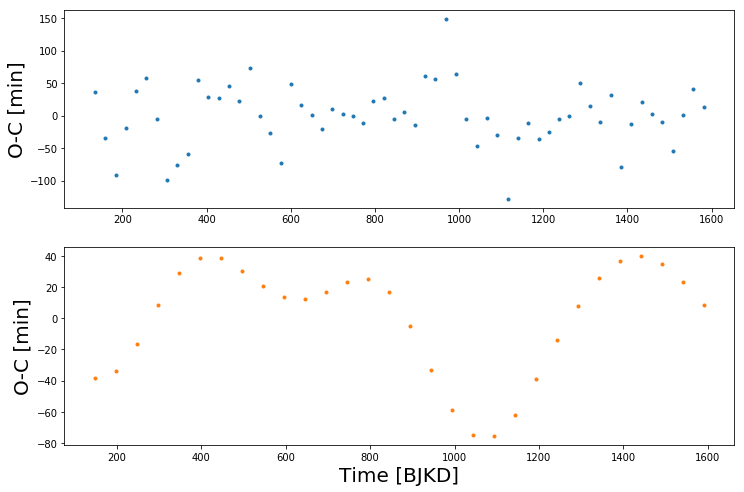

In [17]:
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = poly.polyval(p.index, poly.polyfit(p.index, p.tts, 1))
    yomc  = (p.tts - xtime)*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_initial.pdf', bbox_inches='tight')
plt.show()

In [18]:
FULL_FIXED_EPHEMERIS = []
FULL_FIXED_INDS = []

for npl, p in enumerate(planets):
    FULL_FIXED_EPHEMERIS.append(poly.polyval(p.index, poly.polyfit(p.index, p.tts, 1)))
    FULL_FIXED_INDS.append(np.copy(p.index - p.index.min()))

# Detrend the lightcurves

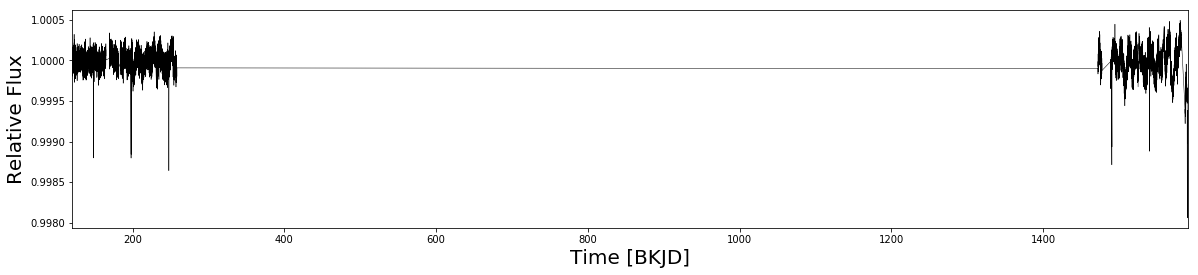

In [19]:
# clean up the LONG CADENCE data
for i, lcq in enumerate(lc_data):
    lcq = detrend.remove_flagged_cadences(lcq)
    
    mask = np.zeros(len(lcq.time), dtype="bool")
    for npl, p in enumerate(planets):
        mask += detrend.make_transitmask(lcq.time, p.tts, p.duration, masksize=1.5)
    
    lcq = detrend.clip_outliers(lcq, kernel_size=5, sigma_upper=5.0, sigma_lower=5.0, mask=mask)
    lcq = detrend.clip_outliers(lcq, kernel_size=5, sigma_upper=5.0, sigma_lower=15.0)
    
    lc_data[i] = lcq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))

    
if len(lc_data) > 0:
    # combine quarters into a single LiteCurve
    lc = detrend.stitch_lkc(lc_data)
    
    # make a mask where planets transit
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)

    lc.mask = deepcopy(lc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(lc.time, lc.flux, c="k", lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.show()
    
else:
    lc = None

optimizing logp for variables: [logvar, flux0]
10it [00:00, 128.42it/s, logp=3.606288e+03]
message: Optimization terminated successfully.
logp: 3606.286647809341 -> 3606.2882907906837
optimizing logp for variables: [log_deltaQ, log_Q0_off, log_per_off, mix, log_amp]
53it [00:00, 184.20it/s, logp=3.694858e+03]
message: Optimization terminated successfully.
logp: 3606.2882907906837 -> 3694.858189387945
optimizing logp for variables: [exp_amp, logtau]
167it [00:00, 350.46it/s, logp=3.695978e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 3694.858189387945 -> 3695.977548281371
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
64it [00:00, 283.19it/s, logp=3.696249e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 3695.977548281371 -> 3696.2485829233797
optimizing logp for variables: [logvar, flux0]
46it [00:00, 219.26it/s, logp=1.201519e+04]
message: Desired er

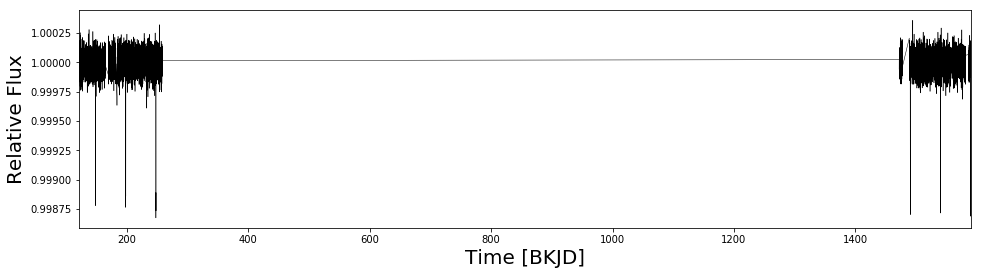

In [20]:
if lc is not None:    
    # detrend
    break_tolerance = int(DURS.min()/(LCIT/60/24)*5/2)
    min_period = 5*DURS.max()
    
    lc = detrend.flatten_with_gp(lc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    lc.season = lc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(lc.time, lc.flux, c='k', lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

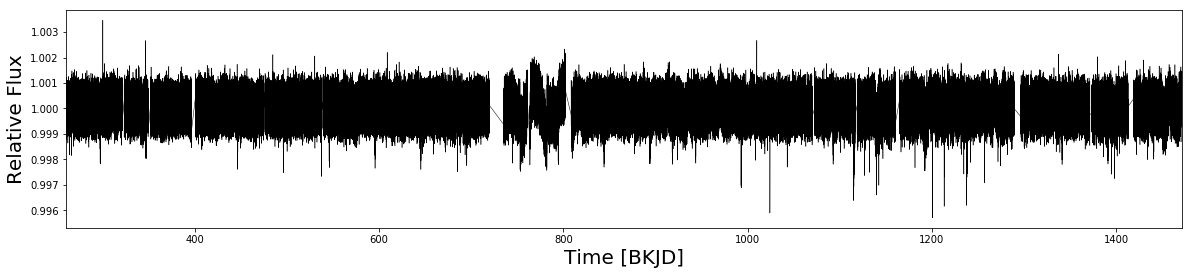

In [21]:
# clean up the SHORT CADENCE data
for i, scq in enumerate(sc_data):
    scq = detrend.remove_flagged_cadences(scq)
    
    mask = np.zeros(len(scq.time), dtype="bool")
    for npl, p in enumerate(planets):
        mask += detrend.make_transitmask(scq.time, p.tts, p.duration, masksize=1.5)
    
    scq = detrend.clip_outliers(scq, kernel_size=5, sigma_upper=5.0, sigma_lower=5.0, mask=mask)
    scq = detrend.clip_outliers(scq, kernel_size=5, sigma_upper=5.0, sigma_lower=15.0)
    
    sc_data[i] = scq


# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))

    
if len(sc_data) > 0:
    # combine quarters into a single LiteCurve
    sc = detrend.stitch_lkc(sc_data)
    
    # make a mask where planets transit
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = deepcopy(sc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(sc.time, sc.flux, c="k", lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.show()
    
else:
    sc = None

optimizing logp for variables: [logvar, flux0]
78it [00:06, 11.48it/s, logp=7.800692e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 779969.2888827019 -> 780069.2294760754
optimizing logp for variables: [log_deltaQ, log_Q0_off, log_per_off, mix, log_amp]
152it [00:18,  8.64it/s, logp=7.806076e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 780069.2294760754 -> 780607.596686274
optimizing logp for variables: [exp_amp, logtau]
113it [00:07, 14.87it/s, logp=7.806084e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 780607.596686274 -> 780608.4306906317
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
209it [00:24,  8.67it/s, logp=7.806123e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 780608.4306906317 -> 780612.3453306486
optimizing logp for variables: [logvar, flux0]
77it [00:07, 11.57it/s

optimizing logp for variables: [logvar, flux0]
95it [00:05, 16.10it/s, logp=6.705643e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 670458.3070225581 -> 670564.2718815163
optimizing logp for variables: [log_deltaQ, log_Q0_off, log_per_off, mix, log_amp]
122it [00:11, 11.18it/s, logp=6.709048e+05]
message: Optimization terminated successfully.
logp: 670564.2718815163 -> 670904.7790293001
optimizing logp for variables: [exp_amp, logtau]
145it [00:07, 18.19it/s, logp=6.709185e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 670904.7790293001 -> 670918.5089954969
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
187it [00:15,  9.42it/s, logp=6.709250e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 670918.5089954969 -> 670925.0177555609
optimizing logp for variables: [logvar, flux0]
109it [00:08, 13.19it/s, logp=7.878089e+05]


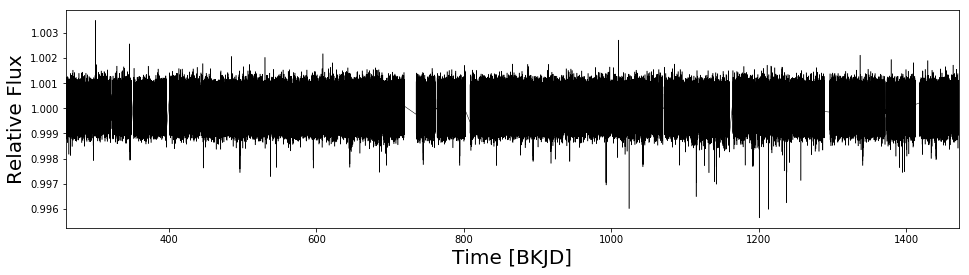

In [22]:
if sc is not None:    
    # detrend
    break_tolerance = int(DURS.min()/(SCIT/3600/24)*5/2)
    min_period = 5*DURS.max()
    
    sc = detrend.flatten_with_gp(sc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    sc.season = sc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(sc.time, sc.flux, c='k', lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

# Make individual mask for where each planet transits
### These masks have width 2.5 transit durations, which may be wider than the masks used for detrending

In [23]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=2.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=2.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

Making transit masks


# Flag which transits have photometry coverage in transit (quality = 1)

In [24]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        try:
            neartransit_sc = np.abs(sc.time - t0)/p.duration < 0.5
            neartransit_lc = np.abs(lc.time - t0)/p.duration < 0.5
        
            quality.append((np.sum(neartransit_sc) + np.sum(neartransit_lc)) > 0)
                        
        except:
            neartransit = np.abs(lc.time - t0)/p.duration < 0.5
            quality.append(np.sum(neartransit) > 0)
        
    p.quality = np.copy(quality)

# Flag which transits overlap (overlap = 1)

In [25]:
# identify overlapping transits
dur_max = np.max(DURS)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(planets[i].tts), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for ttj in planets[j].tts:
                overlap[i] += np.abs(planets[i].tts - ttj)/dur_max < 1.5
                
    planets[i].overlap = np.copy(overlap[i])

# Count up transits and calculate initial fixed transit times

In [26]:
num_transits  = np.zeros(NPL)
transit_inds  = []
fixed_tts = []

for npl, p in enumerate(planets):
    transit_inds.append(np.array((p.index - p.index.min())[p.quality], dtype="int"))
    fixed_tts.append(np.copy(p.tts)[p.quality])
    
    num_transits[npl] = len(transit_inds[npl])
    transit_inds[npl] -= transit_inds[npl].min()

# Grab the relevant data and starting transit parameters

In [27]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_error = []
all_dtype = []

lc_flux = []
sc_flux = []

if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_error.append(sc.error[use])
                all_dtype.append('short')

                sc_flux.append(sc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 5:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)


# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

In [28]:
# pull basic transit parameters
epochs    = np.zeros(NPL)
periods   = np.zeros(NPL)
depths    = np.zeros(NPL)
durations = np.zeros(NPL)
impacts   = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]    = p.epoch
    periods[npl]   = p.period
    depths[npl]    = p.depth
    durations[npl] = p.duration
    impacts[npl]   = p.impact

radii = np.sqrt(depths)*RSTAR

In [29]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  3752 s



# (1) Fit transit SHAPE model

The TTV model when determining transit shape is built as perturbations from fixed (i.e. invariant) transit times. These transit times ("FIXED_TTS") are not varied during model fitting. If TTVs are available from Holczer+ 2016, these are used; if not, the fixed transit times determined from a linear ephemeris using Kepler pipeline epoch and period.

Long-term, secular TTVs are parameterized as Legendre polynomials as functions of dimensionless variable ("x") in the range (-1,1)

Unlike the transit time and index values attached to each Planet object, there may be gaps in the FIXED_TTS vector where there is no available photometric data.

In [30]:
print('\n(1) Fitting transit SHAPE model')


(1) Fitting transit SHAPE model


In [31]:
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a baseline in the range (TIME_START,TIME_END)
for npl, p in enumerate(planets):    
    t.append(p.epoch + transit_inds[npl]*p.period)
    x = 2*(t[npl]-TIME_START)/(TIME_END-TIME_START) - 1

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

In [32]:
with pm.Model() as shape_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Bound(pm.Normal, lower=RSTAR-3*RSTAR_ERR, upper=RSTAR+3*RSTAR_ERR)('Rstar', mu=RSTAR, sd=RSTAR_ERR)
    Mstar = pm.Bound(pm.Normal, lower=MSTAR-3*MSTAR_ERR, upper=MSTAR+3*MSTAR_ERR)('Mstar', mu=MSTAR, sd=MSTAR_ERR)


    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)
    
    
    # polynomial TTV parameters    
    C0 = pm.Normal('C0', mu=0.0, sd=durations/2, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=durations/2, shape=NPL)
    
    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              fixed_tts[npl] + C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl]))
    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=1.0, sd=np.std(good_flux))

    if len(sc_flux_lin) > 1:
        logvar = pm.Normal('logvar', mu=np.log(np.var(sc_flux_lin)), sd=np.log(4))
    else:
        logvar = pm.Normal('logvar', mu=np.log(np.var(lc_flux_lin)*30), sd=np.log(4))
    
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    obs = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        

        if all_dtype[q] == 'short':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)),
                               observed=all_flux[q])
        
        elif all_dtype[q] == 'long':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)/30),
                               observed=all_flux[q])
            
        else:
            raise ValueError("Cadence data type must be 'short' or 'long'")


In [33]:
with shape_model:
    shape_map = exo.optimize(start=shape_model.test_point, vars=[flux0, logvar])
    shape_map = exo.optimize(start=shape_map, vars=[b])
    shape_map = exo.optimize(start=shape_map, vars=[u, Mstar])
    shape_map = exo.optimize(start=shape_map, vars=[C0, C1])
    shape_map = exo.optimize(start=shape_map)

optimizing logp for variables: [logvar, flux0]
153it [00:10, 15.00it/s, logp=6.292489e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 623871.2204969007 -> 629248.9223259025
optimizing logp for variables: [b, logr, Rstar]
47it [00:01, 31.54it/s, logp=6.293990e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 629248.9223259025 -> 629399.0352368287
optimizing logp for variables: [Mstar, u]
21it [00:00, 26.68it/s, logp=6.296850e+05]
message: Optimization terminated successfully.
logp: 629399.0352368287 -> 629684.9984884722
optimizing logp for variables: [C1, C0]
32it [00:04,  6.76it/s, logp=6.310027e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 629684.9984884722 -> 631002.7275437184
optimizing logp for variables: [logvar, flux0, C1, C0, b, logr, Mstar, Rstar, u]
202it [00:14, 13.65it/s, logp=6.312999e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 631002.7

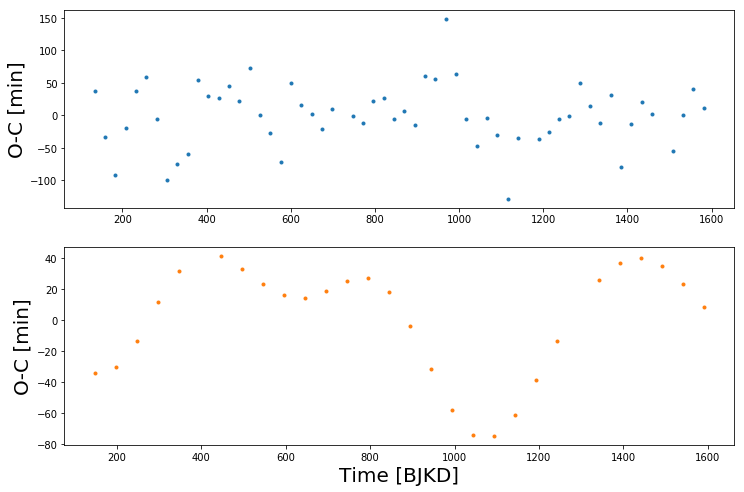

In [34]:
# grab transit times and ephemeris
shape_transit_times = []
shape_ephemeris = []

for npl, p in enumerate(planets):
    shape_transit_times.append(shape_map['tts_{0}'.format(npl)])
    shape_ephemeris.append(shape_map['P'][npl]*transit_inds[npl] + shape_map['T0'][npl])

    
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = shape_transit_times[npl]
    yomc  = (shape_transit_times[npl] - shape_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [35]:
# update stellar parameter values
Rstar = shape_map['Rstar']
Mstar = shape_map['Mstar']
u = shape_map['u']


# update planet parameter values
periods = shape_map['P']
epochs  = shape_map['T0']

rp = shape_map['rp']
b  = shape_map['b']

sma  = get_sma(periods, Mstar)
durs = get_dur_tot(periods, rp, Rstar, b, sma)


for npl, p in enumerate(planets):
    p.epoch    = epochs[npl]
    p.period   = periods[npl]
    p.depth    = (rp[npl]/Rstar)**2
    p.duration = durs[npl]
    p.impact   = b[npl]

In [36]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  4151 s



# (2) Fit slide TTVs

In [37]:
print('\n(2) Fitting SLIDE TTVs')


(2) Fitting SLIDE TTVs


In [38]:
slide_transit_times = []
slide_error = []

t_all = np.array(np.hstack(all_time), dtype="float")
f_all = np.array(np.hstack(all_flux), dtype="float")

for npl, p in enumerate(planets):
    print("\nPLANET", npl)
    
    slide_transit_times.append([])
    slide_error.append([])
    
    # create template transit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.KeplerianOrbit(t0=0, period=p.period, b=b[npl], r_star=Rstar, m_star=Mstar)

    gridstep     = scit/2
    slide_offset = 1.0
    delta_chisq  = 2.0

    template_time = np.arange(-p.duration*(slide_offset+1.5), p.duration*(slide_offset+1.5), gridstep)
    template_flux = 1.0 + exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=template_time).sum(axis=-1).eval()  
    
        
    
    # empty lists to hold new transit time and uncertainties
    tts = -99*np.ones_like(shape_transit_times[npl])
    err = -99*np.ones_like(shape_transit_times[npl])
    
    for i, t0 in enumerate(shape_transit_times[npl]):
        #print(i, np.round(t0,2))
        if ~p.overlap[p.quality][i]:
        
            # grab flux near each non-overlapping transit
            use = np.abs(t_all - t0)/p.duration < 2.5
            mask = np.abs(t_all - t0)/p.duration < 1.0

            t_ = t_all[use]
            f_ = f_all[use]
            m_ = mask[use]

            trend = poly.polyval(t_, poly.polyfit(t_[~m_], f_[~m_], 1))
            
            
            f_ /= trend
            e_ = np.ones_like(f_)*np.std(f_[~m_])
            

            tc_vector = t0 + np.arange(-p.duration*slide_offset, p.duration*slide_offset, gridstep)
            chisq_vector = np.zeros_like(tc_vector)

            # slide along transit time vector and calculate chisq
            for j, tc in enumerate(tc_vector):
                y_ = np.interp(t_-tc, template_time, template_flux)
                chisq_vector[j] = np.sum((f_ - y_)**2/e_**2)

            chisq_vector = boxcar_smooth(chisq_vector, winsize=7)


            # grab points near minimum chisq
            delta_chisq = 1
            
            loop = True
            while loop:
                # incrememnt delta_chisq and findminimum
                delta_chisq += 1
                min_chisq = chisq_vector.min()
                
                # grab the points near minimum
                tcfit = tc_vector[chisq_vector < min_chisq+delta_chisq]
                x2fit = chisq_vector[chisq_vector < min_chisq+delta_chisq]

                # eliminate points far from the local minimum
                spacing = np.median(tcfit[1:]-tcfit[:-1])
                faraway = np.abs(tcfit-np.median(tcfit))/spacing > 1 + len(tcfit)/2
                
                tcfit = tcfit[~faraway]
                x2fit = x2fit[~faraway]
                
                # check for stopping conditions
                if len(x2fit) >= 3:
                    loop = False
                    
                if delta_chisq >= 9:
                    loop = False
                    
                    
            # fit a parabola around the minimum (need at least 3 pts)
            if len(tcfit) < 3:
                #print("TOO FEW POINTS")
                tts[i] = np.nan
                err[i] = np.nan

            else:
                quad_coeffs = np.polyfit(tcfit, x2fit, 2)
                quadfit = np.polyval(quad_coeffs, tcfit)
                qtc_min = -quad_coeffs[1]/(2*quad_coeffs[0])
                qx2_min = np.polyval(quad_coeffs, qtc_min)
                qtc_err = np.sqrt(1/quad_coeffs[0])

                # here's the fitted transit time
                tts[i] = np.mean([qtc_min,np.median(tcfit)])
                err[i] = qtc_err*1.0

                # check that the fit is well-conditioned (ie. a negative t**2 coefficient)
                if quad_coeffs[0] <= 0.0:
                    #print("INVERTED PARABOLA")
                    tts[i] = np.nan
                    err[i] = np.nan

                # check that the recovered transit time is within the expected range
                if (tts[i] < tcfit.min()) or (tts[i] > tcfit.max()):
                    #print("T0 OUT OF BOUNDS")
                    tts[i] = np.nan
                    err[i] = np.nan


            # show plots
            if ~np.isnan(tts[i]):
                do_plots = False
                    
                if do_plots:
                    fig, ax = plt.subplots(1,2, figsize=(10,3))

                    ax[0].plot(t_-tts[i], f_, "ko")
                    ax[0].plot((t_-tts[i])[m_], f_[m_], "o", c="C{0}".format(npl))
                    ax[0].plot(template_time, template_flux, c="C{0}".format(npl), lw=2)

                    ax[1].plot(tcfit, x2fit, "ko")
                    ax[1].plot(tcfit, quadfit, c="C{0}".format(npl), lw=3)
                    ax[1].axvline(tts[i], color="k", ls="--", lw=2)

                    plt.show()

            
            
        else:
            #print("OVERLAPPING TRANSITS")
            tts[i] = np.nan
            err[i] = np.nan
        
    slide_transit_times[npl] = np.copy(tts)
    slide_error[npl] = np.copy(err)


PLANET 0

PLANET 1


In [39]:
for npl, p in enumerate(planets):
    bad = np.isnan(slide_transit_times[npl]) + np.isnan(slide_error[npl])
    bad += slide_error[npl] > 8*np.nanmedian(slide_error[npl])
    
    slide_transit_times[npl][bad] = shape_transit_times[npl][bad]
    slide_error[npl][bad] = np.nan

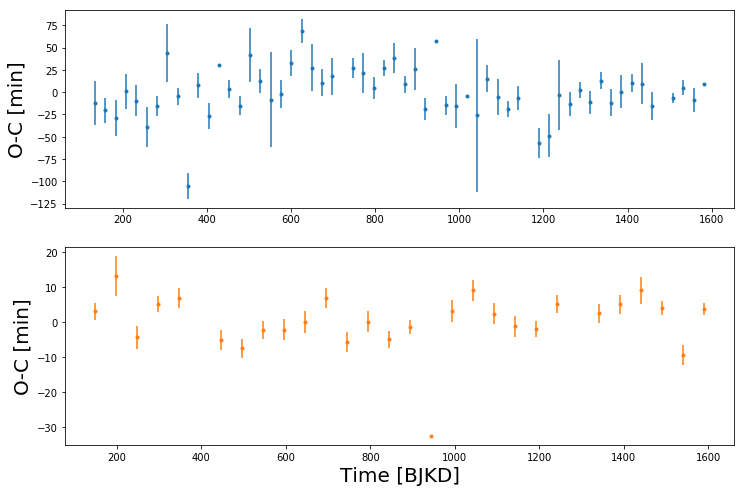

In [40]:
# grab transit times and ephemeris
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    ephem = poly.polyval(transit_inds[npl], poly.polyfit(transit_inds[npl], slide_transit_times[npl], 1))
    
    xtime = slide_transit_times[npl]
    yomc  = (slide_transit_times[npl] - ephem)*24*60
    yerr  = slide_error[npl]*24*60
    
    axes[npl].errorbar(xtime, yomc, yerr=yerr, fmt='.', color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

# (3) Fit MAP independent TTVs

In [41]:
print('\n(3) Fitting INDEPENDENT TTVs')


(3) Fitting INDEPENDENT TTVs


In [42]:
with pm.Model() as indep_model:
    # transit times
    tt_offset = []
    transit_times = []
    
    for npl in range(NPL):
        tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0, sd=1, shape=len(slide_transit_times[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl),
                                              slide_transit_times[npl] + tt_offset[npl]*durations[npl]/3))
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
        
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=1.0, sd=np.std(good_flux))

    if len(sc_flux_lin) > 1:
        logvar = pm.Normal('logvar', mu=np.log(np.var(sc_flux_lin)), sd=np.log(4))
    else:
        logvar = pm.Normal('logvar', mu=np.log(np.var(lc_flux_lin)*30), sd=np.log(4))
    
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    obs = [None]*nq
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        
        if all_dtype[q] == 'short':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)),
                               observed=all_flux[q])
        
        elif all_dtype[q] == 'long':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)/30),
                               observed=all_flux[q])
            
        else:
            raise ValueError("Cadence data type must be 'short' or 'long'")

In [43]:
with indep_model:
    indep_map = exo.optimize(start=indep_model.test_point, vars=[flux0, logvar])
    
    for npl in range(NPL):
        indep_map = exo.optimize(start=indep_map, vars=[tt_offset[npl]])
        
    indep_map = exo.optimize(start=indep_map)

optimizing logp for variables: [logvar, flux0]
38it [00:01, 29.17it/s, logp=6.337678e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 626450.6288452713 -> 633767.7883712112
optimizing logp for variables: [tt_offset_0]
182it [00:10, 17.34it/s, logp=6.337828e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 633767.7883712112 -> 633782.7587022404
optimizing logp for variables: [tt_offset_1]
130it [00:08, 14.76it/s, logp=6.338396e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 633782.7587022404 -> 633839.6245571827
optimizing logp for variables: [logvar, flux0, tt_offset_1, tt_offset_0]
200it [00:13, 14.61it/s, logp=6.338450e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 633839.6245571827 -> 633845.0205159867


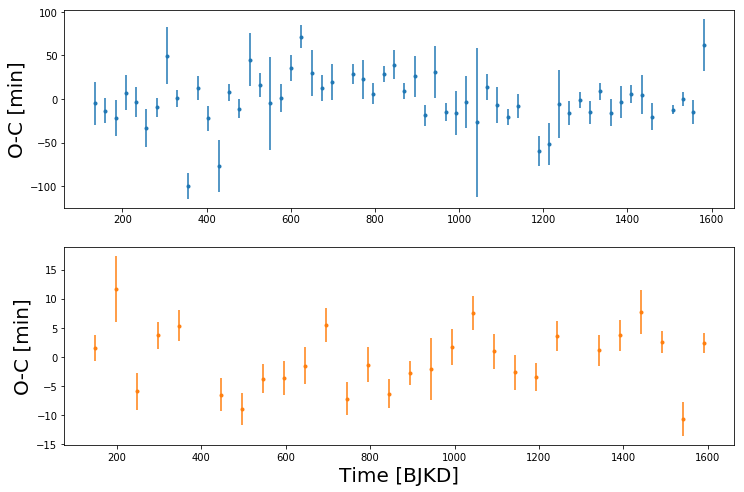

In [44]:
indep_transit_times = []
indep_ephemeris = []
full_indep_ephemeris = []

indep_error = np.copy(slide_error)

for npl, p in enumerate(planets):
    # pull the MAP solution
    indep_transit_times.append(indep_map['tts_{0}'.format(npl)])
    indep_ephemeris.append(indep_map['P'][npl]*transit_inds[npl] + indep_map['T0'][npl])
    full_indep_ephemeris.append(indep_map['P'][npl]*p.index + indep_map['T0'][npl])

    # replace the MAP TTVs with SLIDE TTVs where applicable
    replace = ~np.isnan(slide_error[npl])
    indep_transit_times[npl][replace] = np.copy(slide_transit_times[npl][replace])
    
    indep_error[npl][~replace] = np.std(indep_transit_times[npl] - indep_ephemeris[npl])
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    yerr  = (indep_error[npl])*24*60
    
    axes[npl].errorbar(xtime, yomc, yerr=yerr, fmt='.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_indep.pdf', bbox_inches='tight')
plt.show()

In [45]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  4391 s



# Fit a Matern-3/2 kernel GP directly to the independent TTVs

In [46]:
print("Fitting a MATERN-3/2 GP to independent TTVs")

Fitting a MATERN-3/2 GP to independent TTVs



PLANET 0

iteration 1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho, log_sigma]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:59<00:00, 115.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]
100%|██████████| 4000/4000 [00:13<00:00, 304.61it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


loc [0.00522287]
scale [1.09334385 0.90338959]
7 outliers found out of 57 transit times (12.3%)

iteration 2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho, log_sigma]
Sampling 2 chains: 100%|██████████| 15000/15000 [01:09<00:00, 215.49draws/s]
The acceptance probability does not match the target. It is 0.8340752626420828, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8104994166848453, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


BAD FRACTION = 0.09494152046783626


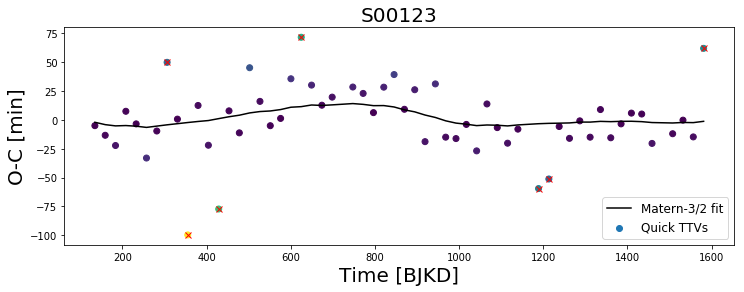


PLANET 1

iteration 1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho, log_sigma]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:41<00:00, 357.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]
100%|██████████| 4000/4000 [00:08<00:00, 452.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


loc [-0.00552989]
scale [1.02508142 1.03603106]
0 outliers found out of 28 transit times (0.0%)
BAD FRACTION = 0.2786904761904762


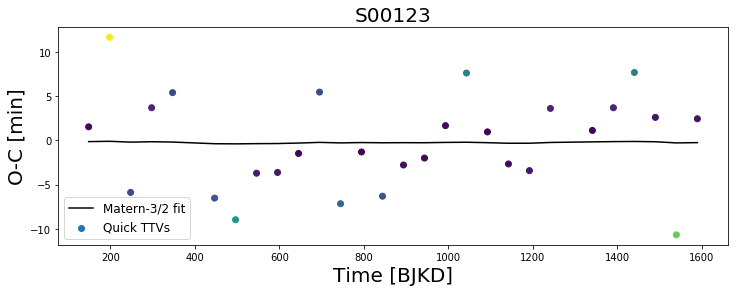

In [47]:
matern_ephemeris = []
matern_transit_times = []

matern_log_sigma = np.zeros((NPL,2))
matern_log_rho = np.zeros((NPL,2))


for npl, p in enumerate(planets):
    print("\nPLANET", npl)
    xtime = indep_ephemeris[npl]
    yomc  = indep_transit_times[npl] - indep_ephemeris[npl]
    yerr  = indep_error[npl]

    ymed = ndimage.median_filter(yomc, size=5, mode="mirror")
    out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 5.0
 

    loop = True
    iteration = 0
    while loop:
        iteration += 1
        print("\niteration", iteration)

        # fit a GP with a Matern-3/2 kernel
        with pm.Model() as matern_model:
            # build the kernel 
            log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=10)
            log_rho = pm.Normal("log_rho", mu=np.log(xtime[1]-xtime[0]), sd=10)

            kernel = exo.gp.terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)

            # nusiance parameters
            mean = pm.Normal("mean", mu=np.mean(yomc), sd=10)
            logvar = pm.Normal("logvar", mu=np.log(np.var(yomc)), sd=10)

            # here's the GP
            gp = exo.gp.GP(kernel, xtime[~out], T.exp(logvar)*T.ones(len(xtime[~out])))

            # add custom potential (log-prob fxn) with the GP likelihood
            pm.Potential("obs", gp.log_likelihood(yomc[~out] - mean))

            # track GP prediction
            gp_pred = pm.Deterministic("gp_pred", gp.predict(indep_ephemeris[npl]))
            
            full_trend = pm.Deterministic("full_trend", mean + gp.predict(full_indep_ephemeris[npl]))
            part_trend = pm.Deterministic("part_trend", mean + gp.predict(indep_ephemeris[npl]))


        with matern_model:
            matern_trace = pm.sample(tune=6000, draws=1500, start=matern_model.test_point, chains=2, 
                                     step=exo.get_dense_nuts_step(target_accept=0.9))

        
        # stop looping if the maximum number of iterations has been reached
        if iteration >= 2:
            loop = False
        
        else:
            # fit a mixture model to the residuals
            res = yomc - np.nanmedian(matern_trace["part_trend"], 0)
            resnorm = res / np.std(res)
            resnorm -= np.mean(resnorm)

            with pm.Model() as mix_model:
                w = pm.Dirichlet("w", np.array([1.,1.]))
                mu = pm.Normal("mu", mu=0.0, sd=5.0, shape=1)
                tau = pm.Gamma("tau", 1.0, 1.0, shape=2)
                obs = pm.NormalMixture("obs", w, mu=mu*T.ones(2), tau=tau, observed=resnorm)

            with mix_model:
                mix_trace = pm.sample(tune=3000, draws=1000, start=mix_model.test_point, chains=1, 
                                      step=exo.get_dense_nuts_step(target_accept=0.9))


            # calculate foreground/background probabilities
            loc = np.nanmedian(mix_trace["mu"], axis=0)
            scale = np.nanmedian(1/np.sqrt(mix_trace["tau"]), axis=0)

            print("loc", loc)
            print("scale", scale)


            order = np.argsort(scale)
            scale = scale[order]

            z_fg = stats.norm(loc=loc, scale=scale[0]).pdf(resnorm)
            z_bg = stats.norm(loc=loc, scale=scale[1]).pdf(resnorm)

            fg_prob = z_fg/(z_fg+z_bg)


            # use KMeans clustering to assign each point to the foreground or background
            km = KMeans(n_clusters=2)
            group = km.fit_predict(fg_prob.reshape(-1,1))
            centroids = np.array([np.mean(fg_prob[group==0]), np.mean(fg_prob[group==1])])

            bad = group == np.argmin(centroids)
            bad[fg_prob/fg_prob.max() > 0.8] = False
            
            print("{0} outliers found out of {1} transit times ({2}%)".format(np.sum(bad), len(bad), 
                                                                              np.round(100.*np.sum(bad)/len(bad),1)))
            
            
            # check for convergence and update outlier flagss
            if np.alltrue(bad == out):
                loop = False

            out = np.copy(bad)
        

    # save the final results
    mtts = full_indep_ephemeris[npl] + np.nanmedian(matern_trace["full_trend"], 0)
    mephem = poly.polyval(p.index, poly.polyfit(p.index, mtts, 1))
                                                                          
    matern_transit_times.append(mtts)
    matern_ephemeris.append(mephem)   
       
    matern_log_sigma[npl] = np.nanmedian(matern_trace["log_sigma"]), np.std(matern_trace["log_sigma"])
    matern_log_rho[npl] = np.nanmedian(matern_trace["log_rho"]), np.std(matern_trace["log_rho"])

    

    print("BAD FRACTION =", np.sum(np.isnan(matern_trace["gp_pred"]))/np.size(matern_trace["gp_pred"]))
    
    
    # plot the final trend and outliers
    plt.figure(figsize=(12,4))
    plt.scatter(xtime, yomc*24*60, c=1-fg_prob, cmap="viridis", label="Quick TTVs")
    plt.plot(xtime[bad], yomc[bad]*24*60, "rx")
    plt.plot(xtime, np.nanmedian(matern_trace["part_trend"],0)*24*60, "k", label="Matern-3/2 fit")
    plt.xlabel("Time [BJKD]", fontsize=20)
    plt.ylabel("O-C [min]", fontsize=20)
    plt.legend(fontsize=12)
    plt.savefig(FIGURE_DIR + TARGET + '_ttvs_matern_{0}.pdf'.format(npl), bbox_inches='tight')
    plt.title(TARGET, fontsize=20)
    plt.show()

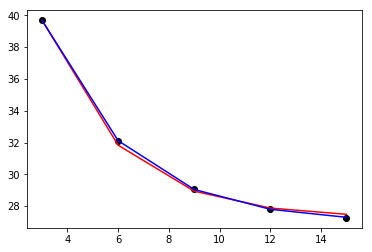

In [48]:
# fit exponential to CDPP values
tdur = np.array([3,6,9,12,15])

def cdpp_fxn(theta, x):
    alpha, beta, x0, tau = theta

    return alpha + beta*np.exp(-(x-x0)/tau)

def res_fxn(theta, x, y):
    return y - cdpp_fxn(theta, x)


theta_guess = [CDPP.min(), CDPP.max()-CDPP.min(), 3.0, 3.0]
theta_out, success = op.leastsq(res_fxn, theta_guess, args=(tdur, CDPP))
    
plt.figure()
plt.plot(tdur, CDPP, "ko")
plt.plot(tdur, cdpp_fxn(theta_guess, tdur), "r")
plt.plot(tdur, cdpp_fxn(theta_out, tdur), "b")
plt.show()

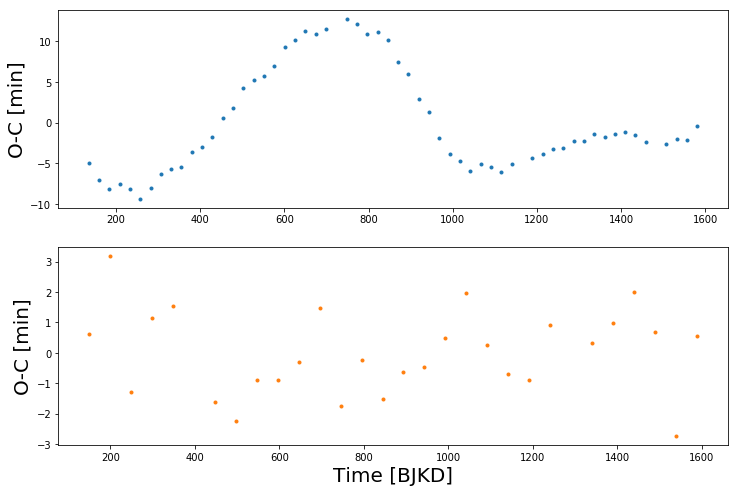

In [49]:
# take weighted average of independent and matern TTVs
quick_transit_times = []
quick_ephemeris = []

for npl, p in enumerate(planets):
    # determine weights based on transit signal-to-noise
    cdpp = cdpp_fxn(theta_out, p.duration*24)
    snr  = p.depth*1e6/cdpp
    w    = (snr/50)**2
    
    # grab transit times
    inds = transit_inds[npl]
    itt = indep_transit_times[npl]
    mtt = matern_transit_times[npl]

    qtt = (1.0*mtt[inds] + w*itt)/(1+w)
    
    quick_transit_times.append(np.copy(qtt))
    quick_ephemeris.append(poly.polyval(inds, poly.polyfit(inds, qtt, 1)))
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = quick_transit_times[npl]
    yomc  = (quick_transit_times[npl] - quick_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_quick.pdf', bbox_inches='tight')
plt.show()

In [50]:
# Save Quick TTV measurements to a text file
for npl in range(NPL):
    data_out  = np.vstack([transit_inds[npl], quick_transit_times[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_quick_ttvs.txt'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f'), delimiter='\t')

In [51]:
# update transit times in Planet objects
for npl, p in enumerate(planets):
    p.tts = np.copy(matern_transit_times[npl])
    p.tts[transit_inds[npl]] = np.copy(quick_transit_times[npl])

# Reject outliers based on transit model
#### Cadences must be flagged as outliers from BOTH the Matern model and the Independent model to be rejected

In [52]:
print("Flagging remaining outliers\n")

Flagging remaining outliers



In [53]:
res_i = []
res_m = []

for j, q in enumerate(quarters):
    print("QUARTER", q)
    
    # grab time and flux data
    if all_dtype[q] == "long":
        use = lc.quarter == q
        t_ = lc.time[use]
        f_ = lc.flux[use]
        
    elif all_dtype[q] == "short":
        use = sc.quarter == q
        t_ = sc.time[use]
        f_ = sc.flux[use]
        
    
    # grab transit times for each planet
    wp_i = []
    tts_i = []
    inds_i = []
    
    wp_m = []
    tts_m = []
    inds_m = []
    
    for npl in range(NPL):
        itt = indep_transit_times[npl]
        mtt = matern_transit_times[npl][transit_inds[npl]]
        
        use_i = (itt > t_.min())*(itt < t_.max())
        use_m = (mtt > t_.min())*(mtt < t_.max())
        
        if np.sum(use_i) > 0:
            wp_i.append(npl)
            tts_i.append(itt[use_i])
            inds_i.append(transit_inds[npl][use_i] - transit_inds[npl][use_i][0])
            
        if np.sum(use_m) > 0:
            wp_m.append(npl)
            tts_m.append(itt[use_m])
            inds_m.append(transit_inds[npl][use_m] - transit_inds[npl][use_m][0])
            

    
    # first check independent transit times
    wp = np.copy(wp_i)
    tts = np.copy(tts_i)
    inds = np.copy(inds_i)
    
    if len(tts) > 0:
        # set up model
        exoSLC = exo.StarryLightCurve(u)
        orbit  = exo.orbits.TTVOrbit(transit_times=tts, transit_inds=inds, period=list(periods[wp]), 
                                     b=b[wp], r_star=Rstar, m_star=Mstar)

        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15

        # calculate light curves
        light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp[wp], t=t_, oversample=oversample)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()

    else:
        model_flux = np.ones_like(f_)*np.mean(f_)
    
    # calculate residuals
    res_i.append(f_ - model_flux)
    
    
    
    # then check matern transit times
    wp = np.copy(wp_m)
    tts = np.copy(tts_m)
    inds = np.copy(inds_m)
    
    if len(tts) > 0:
        # set up model
        exoSLC = exo.StarryLightCurve(u)
        orbit  = exo.orbits.TTVOrbit(transit_times=tts, transit_inds=inds, period=list(periods[wp]), 
                                     b=b[wp], r_star=Rstar, m_star=Mstar)

        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15

        # calculate light curves
        light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp[wp], t=t_, oversample=oversample)
        model_flux = 1.0 + pm.math.sum(light_curves, axis=-1).eval()

    else:
        model_flux = np.ones_like(f_)*np.mean(f_)
    
    # calculate residuals
    res_m.append(f_ - model_flux)

QUARTER 1
QUARTER 2
QUARTER 3
QUARTER 4
QUARTER 5
QUARTER 6
QUARTER 7
QUARTER 8
QUARTER 9
QUARTER 10
QUARTER 11
QUARTER 12
QUARTER 13
QUARTER 14
QUARTER 15
QUARTER 16
QUARTER 17



QUARTER 1
   outliers rejected: 1
   marginal outliers: 0


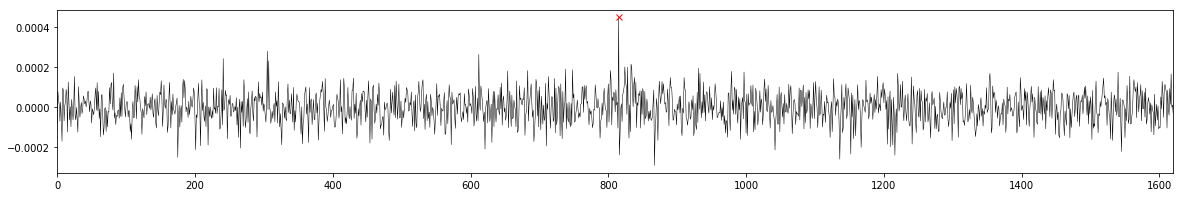


QUARTER 2
   outliers rejected: 2
   marginal outliers: 0


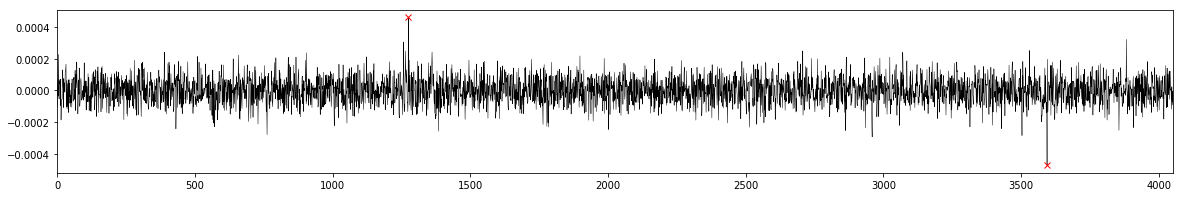


QUARTER 3
   outliers rejected: 6
   marginal outliers: 0


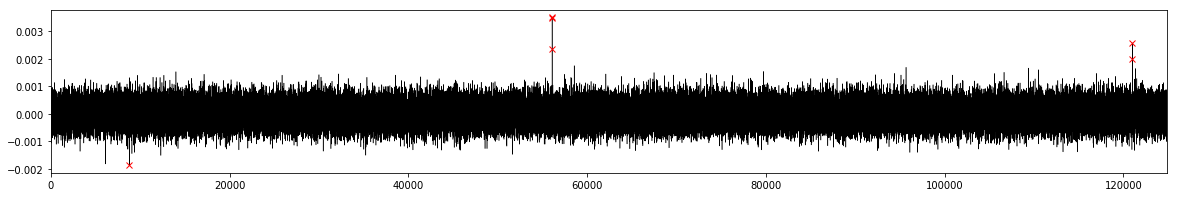


QUARTER 4
   outliers rejected: 0
   marginal outliers: 0


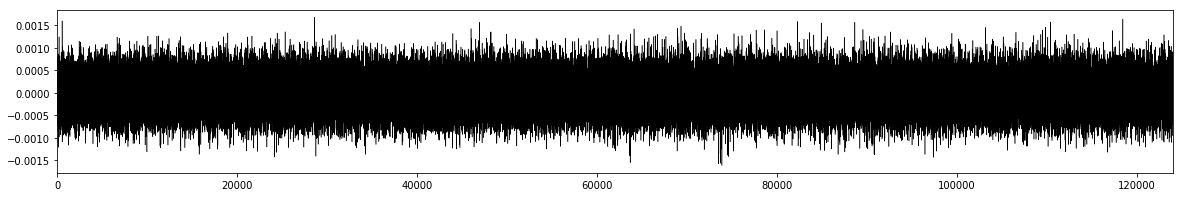


QUARTER 5
   outliers rejected: 5
   marginal outliers: 0


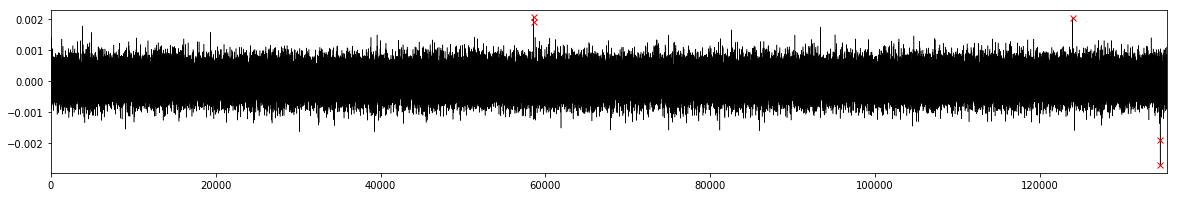


QUARTER 6
   outliers rejected: 2
   marginal outliers: 0


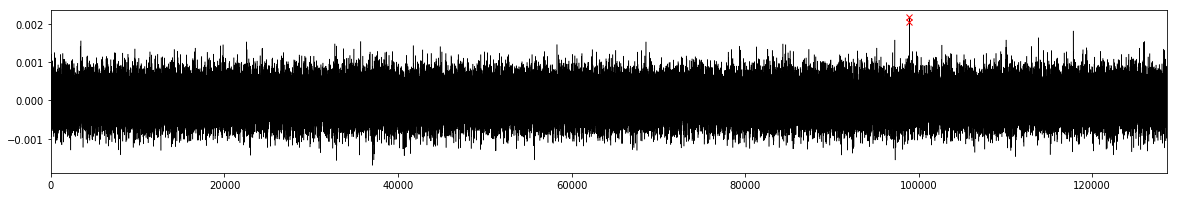


QUARTER 7
   outliers rejected: 3
   marginal outliers: 0


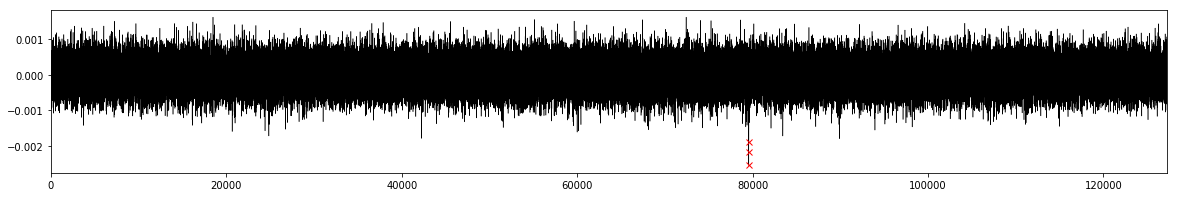


QUARTER 8
   outliers rejected: 0
   marginal outliers: 0


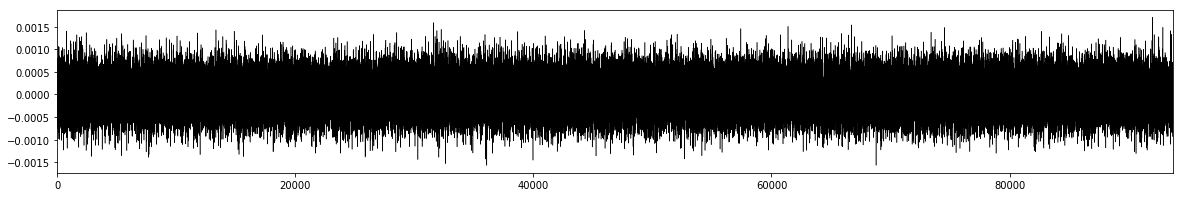


QUARTER 9
   outliers rejected: 1
   marginal outliers: 0


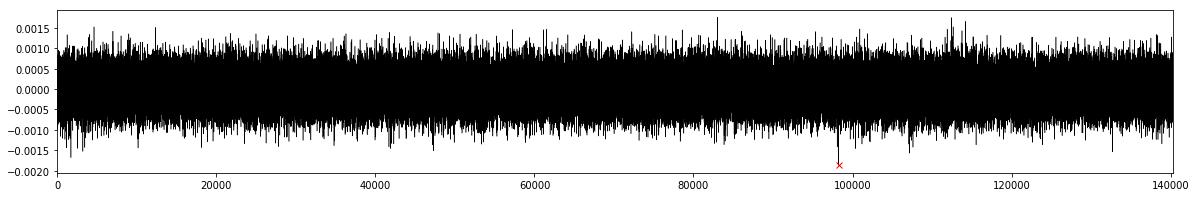


QUARTER 10
   outliers rejected: 5
   marginal outliers: 0


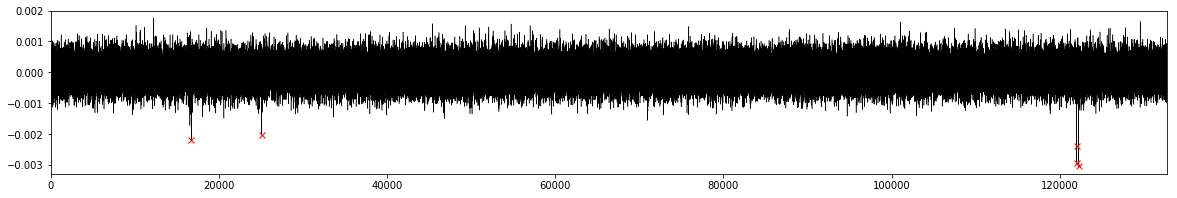


QUARTER 11
   outliers rejected: 9
   marginal outliers: 0


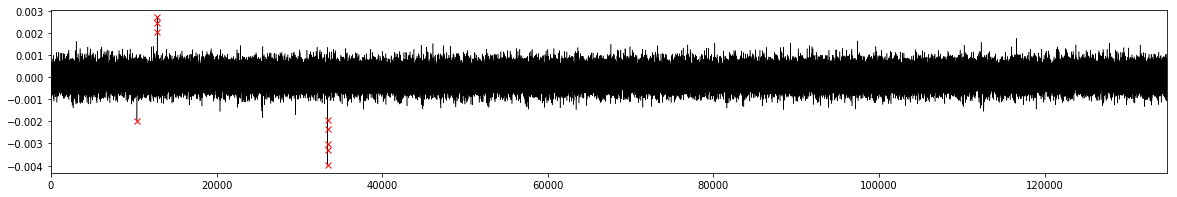


QUARTER 12
   outliers rejected: 16
   marginal outliers: 0


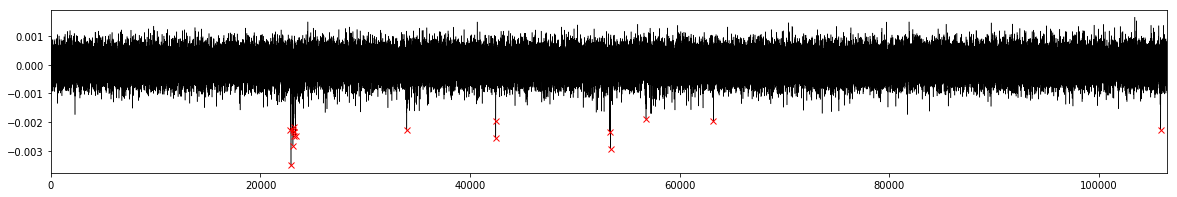


QUARTER 13
   outliers rejected: 16
   marginal outliers: 0


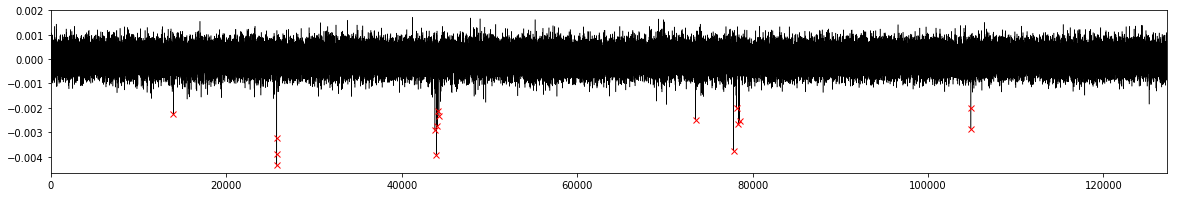


QUARTER 14
   outliers rejected: 1
   marginal outliers: 0


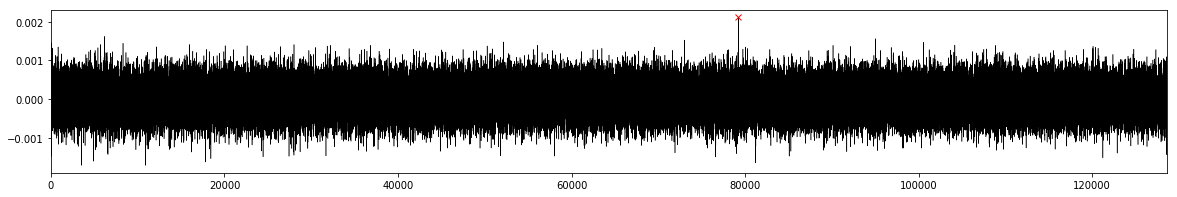


QUARTER 15
   outliers rejected: 9
   marginal outliers: 0


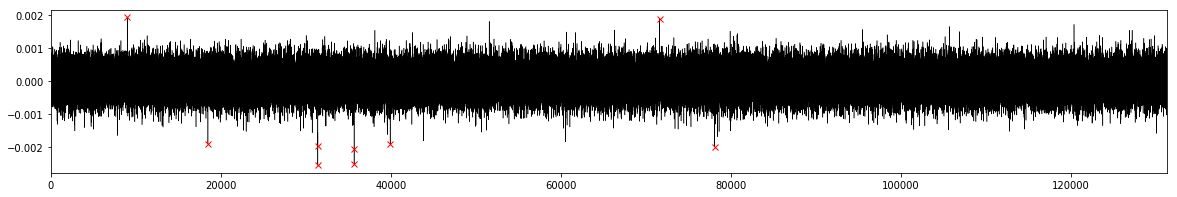


QUARTER 16
   outliers rejected: 0
   marginal outliers: 0


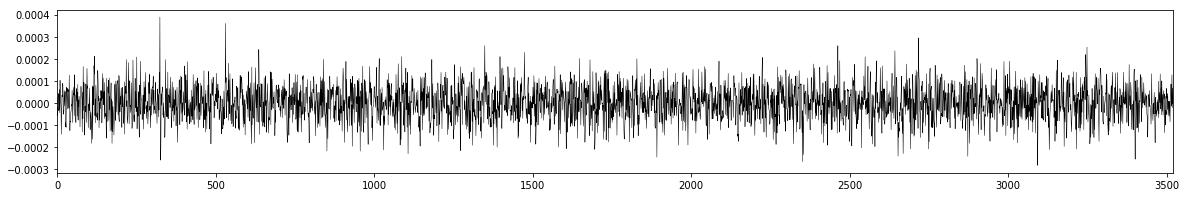


QUARTER 17
   outliers rejected: 0
   marginal outliers: 0


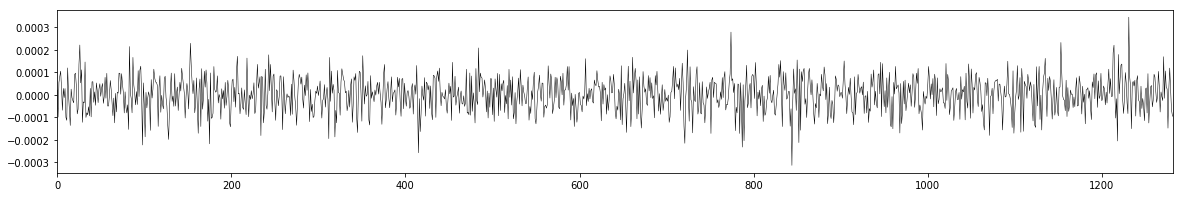

In [54]:
for j, q in enumerate(quarters):
    print("\nQUARTER", q)
    res = 0.5*(res_i[j] + res_m[j])
    x_ = np.arange(len(res))
    
    bad_i = np.abs(res_i[j] - np.mean(res_i[j]))/astropy.stats.mad_std(res_i[j]) > 5.0
    bad_m = np.abs(res_m[j] - np.mean(res_m[j]))/astropy.stats.mad_std(res_m[j]) > 5.0
    
    bad = bad_i * bad_m
    
    print("   outliers rejected:", np.sum(bad))
    print("   marginal outliers:", np.sum(bad_i*~bad_m)+np.sum(~bad_i*bad_m))
    
    plt.figure(figsize=(20,3))
    plt.plot(x_, res, "k", lw=0.5)
    plt.plot(x_[bad], res[bad], "rx")
    plt.xlim(x_.min(), x_.max())
    plt.show()

In [58]:
bad_lc = []
bad_sc = []

for j, q in enumerate(quarters):
    print(j, q)
    
    res = 0.5*(res_i[j] + res_m[j])
    x_ = np.arange(len(res))
    
    bad_i = np.abs(res_i[j] - np.mean(res_i[j]))/astropy.stats.mad_std(res_i[j]) > 5.0
    bad_m = np.abs(res_m[j] - np.mean(res_m[j]))/astropy.stats.mad_std(res_m[j]) > 5.0
    
    bad = bad_i * bad_m
    
    if all_dtype[q] == "short":
        bad_sc = np.hstack([bad_sc, bad])
        print("short", len(bad_sc))

    if all_dtype[q] == "long":
        bad_lc = np.hstack([bad_lc, bad])
        print("long", len(bad_lc))
        
        
bad_lc = np.array(bad_lc, dtype="bool")
bad_sc = np.array(bad_sc, dtype="bool")

0 1
long 1621
1 2
long 5674
2 3
short 124874
3 4
short 248941
4 5
short 384375
5 6
short 513008
6 7
short 640258
7 8
short 734023
8 9
short 874363
9 10
short 1007126
10 11
short 1141914
11 12
short 1248439
12 13
short 1375676
13 14
short 1504289
14 15
short 1635618
15 16
long 9196
16 17
long 10479


In [56]:
len(lc.time), len(bad_lc)

(10943, 10479)

In [61]:
count = 0

for j, q in enumerate(quarters):
    print("QUARTER", q)
    
    # grab time and flux data
    if all_dtype[q] == "long":
        use = lc.quarter == q
        count += len(lc.time[use])
        
    print(count)

QUARTER 1
1621
QUARTER 2
5674
QUARTER 3
5674
QUARTER 4
5674
QUARTER 5
5674
QUARTER 6
5674
QUARTER 7
5674
QUARTER 8
5674
QUARTER 9
5674
QUARTER 10
5674
QUARTER 11
5674
QUARTER 12
5674
QUARTER 13
5674
QUARTER 14
5674
QUARTER 15
5674
QUARTER 16
9196
QUARTER 17
10479


In [64]:
quarters

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [66]:
all_dtype

['none',
 'long',
 'long',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'short',
 'long',
 'long']

In [65]:
lc_quarters

[0, 1, 2, 16, 17]

In [ ]:
if sc is not None:
    sc.time = sc.time[~bad_sc]
    sc.flux = sc.flux[~bad_sc]
    sc.error = sc.error[~bad_sc]
    sc.cadno = sc.cadno[~bad_sc]
    sc.mask  = None

    sc.channel = sc.channel[~bad_sc]
    sc.quarter = sc.quarter[~bad_sc]
    sc.season  = sc.season[~bad_sc]
    sc.centroid_col = sc.centroid_col[~bad_sc]
    sc.centroid_row = sc.centroid_row[~bad_sc]


if lc is not None:
    lc.time = lc.time[~bad_lc]
    lc.flux = lc.flux[~bad_lc]
    lc.error = lc.error[~bad_lc]
    lc.cadno = lc.cadno[~bad_lc]
    lc.mask  = None

    lc.channel = lc.channel[~bad_lc]
    lc.quarter = lc.quarter[~bad_lc]
    lc.season  = lc.season[~bad_lc]
    lc.centroid_col = lc.centroid_col[~bad_lc]
    lc.centroid_row = lc.centroid_row[~bad_lc]

In [ ]:
if sc is not None:
    good_cadno_sc = np.copy(sc.cadno)
    
if lc is not None:
    good_cadno_lc = np.copy(lc.cadno)

# Detrend again with better estimates of transit timing

In [ ]:
# get estimate of ttv amplitude and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(indep_transit_times[npl] - indep_ephemeris[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl] + 0.5/24

In [ ]:
# long cadence
if MISSION == 'Kepler':
    lc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]
    lc_files = glob.glob(lc_path + '*')

    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        olcfi = lk.search.open(lc_files[i])

        if ~np.isin(olcfi.quarter, sc_quarters):
            lc_rawdata_list.append(olcfi)

    lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
    lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)
    
    
elif MISSION == 'Simulated':
    lc_path = DOWNLOAD_DIR + 'Lightcurves/Kepler/simkplr' + '{0:09d}'.format(KIC) + '_lc/'
    lc_files = glob.glob(lc_path + '*')
    
    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        lc_rawdata_list.append(io.load_sim_fits(lcf))
        
    
    quarters = []
    for i, lcrd in enumerate(lc_rawdata_list):
        quarters.append(lcrd.quarter)
        
    order = np.argsort(quarters)
    
    lc_data_list = []
    for j, q in enumerate(quarters):
        lc_data_list.append(lc_rawdata_list[order[j]])

    lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
    lc_data = lk.LightCurveCollection(lc_data_list)
    
    
lc_quarters = []
for i, lcd in enumerate(lc_data):
    lc_quarters.append(lcd.quarter)

In [ ]:
# short cadence
try:
    if MISSION == 'Kepler':
        sc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            oscfi = lk.search.open(sc_files[i])
            sc_rawdata_list.append(oscfi)

        sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        
    elif MISSION == 'Simulated':
        sc_path = DOWNLOAD_DIR + 'Lightcurves/Kepler/simkplr' + '{0:09d}'.format(KIC) + '_sc/'
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            sc_rawdata_list.append(io.load_sim_fits(scf))


        quarters = []
        for i, scrd in enumerate(sc_rawdata_list):
            quarters.append(scrd.quarter)

        order = np.argsort(quarters)

        sc_data_list = []
        for j, q in enumerate(quarters):
            sc_data_list.append(sc_rawdata_list[order[j]])

        sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
        sc_data = lk.LightCurveCollection(sc_data_list)
        
        
except:
    sc_data = []

    
sc_quarters = []
for i, scd in enumerate(sc_data):
    sc_quarters.append(scd.quarter)    

In [ ]:
# clean up the LONG CADENCE data
for i, lcq in enumerate(lc_data):
    lcq = detrend.remove_flagged_cadences(lcq)
    #lcq = detrend.clip_outliers(lcq, kernel_size=5, sigma_upper=5.0, sigma_lower=15.0)
    lc_data[i] = lcq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))

    
if len(lc_data) > 0:
    # combine quarters into a single LiteCurve
    lc = detrend.stitch_lkc(lc_data)
    
    # remove cadences flagged by first fitting iteration
    keep = np.isin(lc.cadno, good_cadno_lc)
    
    lc.time = lc.time[keep]
    lc.flux = lc.flux[keep]
    lc.error = lc.error[keep]
    lc.cadno = lc.cadno[keep]
    lc.quarter = lc.quarter[keep]
    lc.channel = lc.channel[keep]
    lc.centroid_col = lc.centroid_col[keep]
    lc.centroid_row = lc.centroid_row[keep]    
    
    # make a mask where planets transit
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        masksize = np.min([1.5, 0.5 + ttv_buffer[npl]/p.duration])

        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=masksize)

    lc.mask = deepcopy(lc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(lc.time, lc.flux, c="k", lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.show()
    
else:
    lc = None

In [ ]:
if lc is not None:    
    # detrend
    break_tolerance = int(DURS.min()/(LCIT/60/24)*5/2)
    min_period = 5*DURS.max()
    
    lc = detrend.flatten_with_gp(lc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    lc.season = lc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(lc.time, lc.flux, c='k', lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
# clean up the SHORT CADENCE data
for i, scq in enumerate(sc_data):
    scq = detrend.remove_flagged_cadences(scq)
    #scq = detrend.clip_outliers(scq, kernel_size=13, sigma_upper=5.0, sigma_lower=15.0)
    sc_data[i] = scq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))

    
if len(sc_data) > 0:
    # combine quarters into a single LiteCurve
    sc = detrend.stitch_lkc(sc_data)
    
    # remove cadences flagged by first fitting iteration
    keep = np.isin(sc.cadno, good_cadno_sc)
    
    sc.time = sc.time[keep]
    sc.flux = sc.flux[keep]
    sc.error = sc.error[keep]
    sc.cadno = sc.cadno[keep]
    sc.quarter = sc.quarter[keep]
    sc.channel = sc.channel[keep]
    sc.centroid_col = sc.centroid_col[keep]
    sc.centroid_row = sc.centroid_row[keep]
    
    # make a mask where planets transit
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        masksize = np.min([1.5, 0.5 + ttv_buffer[npl]/p.duration])
        
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=masksize)

    sc.mask = deepcopy(sc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(sc.time, sc.flux, c="k", lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.show()
    
else:
    sc = None

In [ ]:
if sc is not None:    
    # detrend
    break_tolerance = int(DURS.min()/(SCIT/3600/24)*5/2)
    min_period = 5*DURS.max()
    
    sc = detrend.flatten_with_gp(sc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    sc.season = sc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(sc.time, sc.flux, c='k', lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

# Make individual mask for where each planet transits
### These masks have width 1.5 transit durations, which may be wider than the masks used for detrending

In [ ]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

# Flag which transits have photometry coverage (quality = 1)

In [ ]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        try:
            neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
        
            quality.append((np.sum(neartransit_sc) + np.sum(neartransit_lc)) > 0)
                        
        except:
            neartransit = np.abs(lc.time - t0)/p.duration < 1.5
            quality.append(np.sum(neartransit) > 0)
        
    p.quality = np.copy(quality)

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Make phase-folded transit plots

In [ ]:
for npl, p in enumerate(planets):
    tts = p.tts[p.quality*~p.overlap]
    
    
    if len(tts) == 0:
        print("No non-overlapping high quality transits found for planet {0} (P = {1} d)".format(npl, p.period))
    
    
    else:
        t_ = []
        f_ = []


        for t0 in tts:
            try:
                neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            except:
                neartransit_sc = None

            try:
                neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
            except:
                neartransit_lc = None

            if (neartransit_lc is not None) and (np.sum(neartransit_lc) > 0):
                t_.append(lc.time[neartransit_lc] - t0)
                f_.append(lc.flux[neartransit_lc])

            if (neartransit_sc is not None) and (np.sum(neartransit_sc) > 0):
                t_.append(sc.time[neartransit_sc] - t0)
                f_.append(sc.flux[neartransit_sc])


        t_ = np.hstack(t_)
        f_ = np.hstack(f_)

        order = np.argsort(t_)
        t_ = t_[order]
        f_ = f_[order]

        f_bin = bin_data(t_, f_, LCIT/60/24/2)
        t_bin = bin_data(t_, t_, LCIT/60/24/2)

        plt.figure(figsize=(12,4))
        plt.plot(t_*24, f_, ".", c="lightgrey")
        plt.plot(t_bin*24, f_bin, "o", ms=5, color="C{0}".format(npl))
        plt.savefig(FIGURE_DIR + TARGET + '_{0:02d}_folded_transit_.pdf'.format(npl), bbox_inches='tight')
        plt.show()

# Generate and model empirical autocorrelation function (ACF)

In [ ]:
# generating figures inside imported modules creates issues with UChicago Midway RCC cluster
# it's easier to just define the function here in the main script

def plot_acf(xcor, acf_emp, acf_mod, xf, yf, freqs, target_name, season):
    """
    Docstring
    """
    fig = plt.figure(figsize=(20,5))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.8)

    ax = plt.subplot2grid(shape=(5,10), loc=(0,0), rowspan=3, colspan=7)
    ax.plot(xcor*24, acf_emp, color='lightgrey')
    ax.plot(xcor*24, acf_mod, c='red')
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xticklabels([])
    ax.set_ylim(acf_emp.min()*1.1, acf_emp.max()*1.1)
    ax.set_ylabel('ACF', fontsize=20)
    ax.text(xcor.max()*24-0.15, acf_emp.max(), '%s, SEASON %d' %(target_name, season), va='top', ha='right', fontsize=20)


    ax = plt.subplot2grid(shape=(5,10), loc=(0,7), rowspan=5, colspan=3)
    ax.plot(xf/24/3600*1e3, yf, color='k', lw=0.5)
    for f in freqs:
        ax.axvline(f/24/3600*1e3, color='red', zorder=0, lw=3, alpha=0.3) 
    ax.set_xlim(xf.min()/24/3600*1e3, xf.max()/24/3600*1e3)
    ax.set_ylim(yf.min(),1.2*yf.max())
    ax.set_ylabel('Power', fontsize=20)
    ax.set_yticks([])
    ax.set_xlabel('Frequency [mHz]', fontsize=20)

    for i, sf in enumerate(np.sort(freqs)[::-1]):
        ax.text(xf.min()/24/3600*1e3+0.1, yf.max()*(1.1-0.1*i), '%.2f min' %(24*60/sf), fontsize=16)


    ax = plt.subplot2grid(shape=(5,10), loc=(3,0), rowspan=2, colspan=7)
    ax.plot(xcor*24, acf_emp-acf_mod, c='lightgrey')
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xlabel('Lag time [hours]', fontsize=20)
    ax.set_ylabel('Residuals', fontsize=20)    
    
    return fig

In [ ]:
# determine what data type each season has
season_dtype = []

sc_seasons = np.unique(np.array(sc_quarters, dtype="int") %4 )
lc_seasons = np.unique(np.array(lc_quarters, dtype="int") %4 )

for z in range(4):
    if np.isin(z, sc_seasons):
        season_dtype.append("short")
    elif np.isin(z, lc_seasons):
        season_dtype.append("long")
    else:
        season_dtype.append("none")

In [ ]:
print('Generating autocorrelation function')
print("Season data types:", season_dtype, "\n")

# grab transit durations
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration

    
# set cutoff between low and high frequency signals
fcut = 2/(LCIT/60/24)
fmin = 2/(5*durations.max())


# now estimate the ACF
acf_lag = []
acf_emp = []
acf_mod = []
acf_freqs = []


for z in range(4):
    if season_dtype[z] == "none":
        acf_lag.append(None)
        acf_emp.append(None)
        acf_mod.append(None)
        acf_freqs.append(None)
        
        
    else:
        if season_dtype[z] == "short":
            Npts = int(5*durations.max()*24*3600/SCIT)
            use = sc.season == z
            m_ = sc.mask.sum(axis=0) > 0
            m_ = m_[use]

            if np.sum(use) > 0:
                t_ = sc.time[use][~m_]
                f_ = sc.flux[use][~m_]
                c_ = sc.cadno[use][~m_]
                
        if season_dtype[z] == "long":
            Npts = int(5*durations.max()*24*60/LCIT)
            use = lc.season == z
            m_ = lc.mask.sum(axis=0) > 0
            m_ = m_[use]

            if np.sum(use) > 0:
                t_ = lc.time[use][~m_]
                f_ = lc.flux[use][~m_]
                c_ = lc.cadno[use][~m_]

                
        if np.sum(use) > 0:
            # generate the empirical acf
            xcor, acor, wcor, acf_stats = noise.generate_acf(t_, f_, c_, Npts)
            
            if season_dtype[z] == "long":
                xcor = xcor*LCIT/60/24
                method = "smooth"
                window_length = 3
            
            if season_dtype[z] == "short":
                xcor = xcor*SCIT/3600/24
                method = "savgol"
                window_length = None

            # model the acf
            acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, 
                                                                method=method, window_length=window_length)

            # make some plots
            fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
            fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}.pdf'.format(z), bbox_inches='tight')
            
            
            # filter out high-frequency components in short cadence data
            if season_dtype[z] == "short":
                fring = freqs[freqs > fcut]
                bw = 1/(lcit-scit/np.sqrt(2))-1/(lcit+scit/np.sqrt(2))

                if len(fring) > 0:
                    flux_filtered = detrend.filter_ringing(sc, break_tolerance, fring, bw)

                    sc.flux[use] = flux_filtered[use]
                    f_ = sc.flux[use][~m_]

                # re-run the ACF modeling on the filtered lightcurve
                xcor, acor, wcor, acf_stats = noise.generate_acf(t_, f_, c_, Npts)
                
                xcor = xcor*SCIT/3600/24
                
                acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, method='savgol')

                fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
                fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}_filtered.pdf'.format(z), bbox_inches='tight')
                
            # add to list
            acf_lag.append(xcor)
            acf_emp.append(acor_emp)
            acf_mod.append(acor_mod)
            acf_freqs.append(freqs)
            
        
        else:
            acf_lag.append(None)
            acf_emp.append(None)
            acf_mod.append(None)
            acf_freqs.append(None)   

# Generate and model synthetic noise

In [ ]:
print('Generating synthetic noise\n')

synth_time  = []
synth_red   = []
synth_white = []


for z in range(4):
    if season_dtype[z] == "none":
        synth_time.append(None)
        synth_red.append(None)
        synth_white.append(None)
       
        
    else:
        if season_dtype[z] == "short":
            print("short")
            Npts = int(2*durations.max()*24*3600/SCIT)
            use = sc.season == z
            m_ = sc.mask.sum(axis=0) > 0
            m_ = m_[use]

            if np.sum(use) > 0:
                t_ = sc.time[use][~m_]
                f_ = sc.flux[use][~m_]
                
        
        if season_dtype[z] == "long":
            print("long")
            Npts = int(5*durations.max()*24*60/LCIT)
            use = lc.season == z
            m_ = lc.mask.sum(axis=0) > 0
            m_ = m_[use]

            if np.sum(use) > 0:
                t_ = lc.time[use][~m_]
                f_ = lc.flux[use][~m_]
                
                
        if np.sum(use) > 0:
            if season_dtype[z] == "long":
                vector_length = 15*len(acf_lag[z])
            if season_dtype[z] == "short":
                vector_length = len(acf_lag[z])
            
            
            # pull and split high/low frequencies
            freqs = acf_freqs[z]

            low_freqs  = freqs[freqs <= fcut]
            high_freqs = freqs[freqs > fcut]


            # generate some synthetic correlated noise
            clipped_acf = (acf_mod[z][:Npts])*np.linspace(1,0,Npts)

            x, red_noise, white_noise = noise.generate_synthetic_noise(acf_lag[z][:Npts], clipped_acf, 
                                                                       vector_length, np.std(f_))

            # add to list
            synth_time.append(x)
            synth_red.append(red_noise)
            synth_white.append(white_noise)


            # plot the noise
            plt.figure(figsize=(20,5))
            plt.plot(x, white_noise + red_noise, '.', c='lightgrey')
            plt.plot(x, red_noise, c='red', lw=4)
            plt.axhline(4/RSRE**2, c='k', ls='--', lw=3)
            plt.axhline(-4/RSRE**2, c='k', ls='--', lw=3)
            plt.xlim(x.min(),x.max())
            plt.xlabel('Time [days]', fontsize=30)
            plt.ylabel('Flux', fontsize=30)
            plt.text(x.max()-0.02, white_noise.max()*0.95, '%s, SEASON %d' %(TARGET, z), va='center', ha='right', fontsize=24)
            plt.savefig(FIGURE_DIR + TARGET + '_synthetic_noise_season_{0}.pdf'.format(z), bbox_inches='tight')
            plt.show()

            
        else:
            synth_time.append(None)
            synth_red.append(None)
            synth_white.append(None)

In [ ]:
print('Fitting a GP to synthetic noise\n')

gp_model  = []
gp_trace  = []
gp_priors = []


for z in range(4):
    if season_dtype[z] == "none":
        gp_model.append(None)
        gp_trace.append(None)
        gp_priors.append(None)
       
        
    else:
        # pull and split high/low frequencies
        freqs = acf_freqs[z]

        low_freqs  = freqs[freqs <= fcut]
        high_freqs = freqs[freqs > fcut]

        if len(low_freqs) > 0:
            lf = [low_freqs[0]]
        else:
            lf = None

        if len(high_freqs) > 0:
            warnings.warn("there are remaining high-frequency noise components")
            
            
        # fit a GP model to the synthetic noise
        gp_model.append(noise.build_sho_model(synth_time[z], synth_red[z], var_method='local', test_freq=lf,
                                              fmin=1/(15*durations.max()), fmax=1/(7*durations.max())))
        
        
        with gp_model[z] as model:
            gp_map = exo.optimize(start=model.test_point, vars=[model.vars[0]])

            for mv in model.vars[1:]:
                gp_map = exo.optimize(start=gp_map, vars=[mv])

            gp_map = exo.optimize(start=gp_map)


        with gp_model[z] as model:
            trace = pm.sample(tune=4000, draws=1000, start=gp_map, chains=2, 
                              step=exo.get_dense_nuts_step(target_accept=0.9))
            
        
        gp_trace.append(trace)
        gp_priors.append(noise.make_gp_prior_dict(gp_trace[z]))

        plt.figure(figsize=(20,4))
        plt.plot(synth_time[z], synth_red[z], c='pink', lw=4)
        plt.plot(synth_time[z], np.nanmedian(gp_trace[z]['gp_pred'], axis=0), c='red')
        plt.xlim(synth_time[z].min(), synth_time[z].max())
        plt.savefig(FIGURE_DIR + TARGET + '_GP_noise_model_{0}.pdf'.format(z), bbox_inches='tight')
        plt.show()

In [ ]:
# list of all quarters with data
quarters = np.sort(np.hstack([lc_quarters, sc_quarters]))

# get variance of each quarter
if lc is not None:
    lcm = lc.mask.sum(axis=0) == 0
if sc is not None:
    scm = sc.mask.sum(axis=0) == 0

var_by_quarter = []

for i, q in enumerate(quarters):
    if (sc is not None) and (np.sum(sc.quarter==q) > 0):
        var_by_quarter.append(np.var(sc.flux[scm*(sc.quarter==q)]))
    elif (lc is not None) and (np.sum(lc.quarter==q) > 0):
        var_by_quarter.append(np.var(lc.flux[lcm*lc.quarter==q]))
    else:
        var_by_quarter.append(None)

# Save detrended lightcurves and estimates of the noise properties

In [ ]:
# Save detrended lightcurves as .fits files
try:
    lc.to_fits(TARGET, DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    print("No long cadence data")

try:
    sc.to_fits(TARGET, DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    print("No short cadence data")

In [ ]:
# Save var_by_quarter
data_out  = np.vstack([quarters, var_by_quarter]).swapaxes(0,1)
fname_out = NOISE_DIR + TARGET + '_var_by_quarter.txt'
    
np.savetxt(fname_out, data_out, fmt=('%1d', '%.15f'), delimiter='\t')


# save gp_priors
for z in range(4):
    try:
        for k in gp_priors[z].keys():
            gp_priors[z][k] = list(gp_priors[z][k])

        fname_out = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)

        with open(fname_out, 'w') as file:
            json.dump(gp_priors[z], file)
            
    except:
        pass

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))